# Example of plotting the predictions

In the first cell you first find the code that was in the generate_model_output.py, so that we get the predicitons. In the cell after you load in the colormap and the cell after shows an example of how to plot it with coordinates.

In [12]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 18 20:27:53 2022

@author: Diewertje
"""
import pandas as pd
import numpy as np
import torch
import os

from nowcasting.config import cfg
from nowcasting.models.encoder import Encoder
from nowcasting.models.forecaster import Forecaster
from nowcasting.net_params import encoder_params, forecaster_params
from nowcasting.models.model import EF
from nowcasting.utils import pixel_to_rainfall
from nowcasting.image import quick_read_frames


def generate_output_model(start_datetime, data_dir, model_name = "all_data_balanced_loss_iteration100", iteration_number = 68000, pixel_type='normalised pixel values'):
    """
    input: 
        start_datetime:   The date of the start of the 5 frames that you need for the prediction. 
                          So this is your t-20 min. 
                          A string, for example: '2018-06-01 13:35:00'
        data_dir:         The path to the directory where you store the data
        model_name:       String withthe name of the folder where the model can be found. 
                          For example: "all_data_balanced_loss_iteration100" 
                          (This is the one you will be working with for now)
        iteration number: Integer to specify from which iteration you want the model. for example 68000
        pixel_type:       The type of pixel values the model is trained on. 
    
    Output: 
            fc:           The forecast for 20 frames in the future (shape=20x480x480) 
            test_data:    The 5 frames you used for the forecast
    """

    # Initialise the encoder_forecaster
    encoder = Encoder(encoder_params[0], encoder_params[1]).to(cfg.GLOBAL.DEVICE)
    forecaster = Forecaster(forecaster_params[0], forecaster_params[1])
    encoder_forecaster = EF(encoder, forecaster).to(cfg.GLOBAL.DEVICE)

    # Load in the trained model
    encoder_forecaster.load_state_dict(torch.load(f"{model_name}/models/encoder_forecaster_{iteration_number}.pth", map_location=torch.device(cfg.GLOBAL.DEVICE)))

    # Load in some constants from the config.py file
    IN_LEN = cfg.HKO.BENCHMARK.IN_LEN
    SEQ_LEN = cfg.HKO.BENCHMARK.SEQ_LEN
    SCALE_FACTOR = cfg.GLOBAL.NORMALIZE

    # Load in the data, which are given in pixel values between 0-255 -> dBZ = value*0.5 - 32
    datetime_clip = pd.date_range(start=start_datetime, periods=SEQ_LEN, freq='5min')
    test_batch = load_frames(datetime_clip, data_dir)

    if pixel_type == 'normalised pixel values':
        test_batch = test_batch.astype(np.float32) / SCALE_FACTOR 
    if pixel_type == 'rainfall rates':
        test_batch = pixel_to_rainfall(test_batch.astype(np.float32))
        
    test_data = test_batch[:IN_LEN, ...]
    torch_test_data = torch.from_numpy(test_data).to(cfg.GLOBAL.DEVICE)

    # calculate output
    with torch.no_grad():
        output = encoder_forecaster(torch_test_data)

    if pixel_type == 'normalised pixel values':
        fc = pixel_to_rainfall(output[:,0,0,:,:]*SCALE_FACTOR)
        test_data = pixel_to_rainfall(test_data*SCALE_FACTOR)
    if pixel_type == 'rainfall rates':
        fc = output[:, 0, 0, :, :]

    return fc, test_data # these values are rainfall rates, for both type of models.

# Since the iterator does not work with the data that I downloaded for some reason, call function separately:
def load_frames(datetime_clips, data_dir):
    """
    In the original function in Eva's dataloader.py, it takes in batchsize=2.
    bus since I now have batchsize is 1, datetime_clips is just 1 list with dates instead of 2.
    therefore, clip is already the datetime that we are interested in.
    the paths is only for if you have batchsize bigger than 1.
    """
    frame_dat = np.zeros((cfg.HKO.BENCHMARK.SEQ_LEN, 1, 1, 480, 480))
    for i, clip in enumerate(datetime_clips):
        path = []
        path = convert_datetime_to_filepath(clip, data_dir)
        frames = quick_read_frames([path]) # I have it now as [path], since quick_read_frames takes the 0th element in it and withouth the list breackets it only reads the rist letter of the string.
        frame_dat[i, 0, 0, :, :] = frames
    return frame_dat

def convert_datetime_to_filepath(date_time, data_dir):
    """
    Convert datetime to filepath (depends on filetype)

    Parameters
    ----------
    date_time : datetime64

    Returns
    -------
    filepath : str

    """

    # for the radar refl tar archive

    year = "%04d" % date_time.year
    month = "%02d" % date_time.month
    day = "%02d" % date_time.day
    next_day = "%02d" % (date_time.day+1)
    hour = "%02d" % date_time.hour
    minute = "%02d" % date_time.minute

    year_folder = f'{year}'
    day_folder = f'{year}-{month}-{day}'
    file_str = f'RAD_NL25_PCP_NA_{year}{month}{day}{hour}{minute}.h5'

    return os.path.join(data_dir, year_folder, day_folder, file_str)

fc, input_data = generate_output_model('2018-06-01 13:35:00', os.getcwd() + '/data_event_2018/')

#### Get the colormap and coordinates

In [2]:
# The colormap:

from pysteps.visualization import precipfields
cmap_pysteps = precipfields.get_colormap('intensity', 'mm/h', colorscale='pysteps')  # other colorscale options: 'STEPS-BE', 'BOM-RF3'

import matplotlib.colors 
# [0.08, 0.16, 0.25, 0.4, 0.63, 0.84, 1, 1.2, 1.4, 1.6, 2, 2.5, 4, 6.3,  10]
new_norm = matplotlib.colors.BoundaryNorm(np.logspace(-2,1, 16),cmap_pysteps[0].N)
new_norm

new_norm2 = matplotlib.colors.BoundaryNorm(np.logspace(-1.3,0.5, 16),cmap_pysteps[0].N)
print(np.logspace(-1.3,1.5,16))

new_norm_30 = matplotlib.colors.BoundaryNorm(np.logspace(-1.3,1.5, 16),cmap_pysteps[0].N)


Pysteps configuration file found at: C:\Users\Diewertje\Python\envs\geo_env\lib\site-packages\pysteps\pystepsrc

[ 0.05011872  0.0770312   0.11839499  0.18197009  0.27968338  0.42986623
  0.66069345  1.01546899  1.56074996  2.39883292  3.68694506  5.66674061
  8.7096359  13.38648842 20.57469156 31.6227766 ]


### Old approach to find the coordinates

The KNMI dataset gives images of 700x765 pixels. This covers north south: 55.97 - 48.9 Longitude (in 765 pixels) and West east: 0-10.86 Latitude (in 700 pixels). (see KNMI website)

The model takes 480x480 as input, and outputs that as well. (See figure 3.4 of Eva's Thesis).

These are the pixels: YMIN = 141, YMAX = 621, XMIN = 109, XMAX = 589

That means that the image goes from:  YMIN = 54.67, YMAX = 50.23, XMIN = 1.69, XMAX = 9.14


**Note: we only want to display the region of interest 360x360 pixels, so this is:
YMIN = 201, YMAX = 661, XMIN = 169, XMAX = 529
That means that the image goes from:  YMIN = 54.11, YMAX = 49.86, XMIN = 2.62, XMAX = 8.21**

In [4]:
# Calculate the longitude
55.97- (55.97-48.9)/765*661

49.861150326797386

In [6]:
# Calculate the latitude
0 + 10.86/700*169

2.6219142857142854

In [17]:
LON_KNMI = np.linspace(54.11, 49.86, 360)   # np.linspace(54.67,50.23,480)
LAT_KNMI = np.linspace(2.62, 8.21, 360)     # np.linspace(1.69, 9.14, 480)

### New approach to find the coordinates (correct)

In [215]:
# The lat and lon on the KNMI website are given in nomral WGS84 I think. only that the array contains stereographic information
llcrnrlon = 0
llcrnrlat = 48.9
urcrnrlon = 10.86
urcrnrlat = 55.97
width = 700
height = 765

lonlist = [llcrnrlon, urcrnrlon]
latlist = [llcrnrlat, urcrnrlat]

These Lat and Lon are in the projection system: PROJ.4+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0. We want to convert them to WGS84, oftewel EPSG:4326, which is WGS84, since that is the coordinate system of the basemap.

This is done in the cells below: (using https://gis.stackexchange.com/questions/253674/converting-projected-coordinates-to-lat-lon-using-pyproj-fails)

#### Get the proj code for the shapefile with the map of the netherlands from naturalearthdata.com

In [216]:
path = 'C:/Users/Diewertje/Documents/Master_GRS/New_Thesis/code_for_group/shapefile_naturalearthdata/ne_10m_admin_0_map_units.prj'
 # change this path to your path, the .prj file is also on the git. (But you do not need this cell for the rest of the notebook)
    
import sys
from osgeo import osr

def esriprj2standards(shapeprj_path):
    with open(shapeprj_path, 'r') as f:
        prj_txt = f.read()
    srs = osr.SpatialReference()
    srs.ImportFromESRI([prj_txt])
    print('Shape prj is: ' + prj_txt)
    print('WKT is: ' + str(srs.ExportToWkt()))
    print('Proj4 is : ' + str(srs.ExportToProj4()))
    srs.AutoIdentifyEPSG()
    print('EPSG is: ' + str(srs.GetAuthorityCode(None)))
    
esriprj2standards(path)

Shape prj is: GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]
WKT is: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]
Proj4 is : +proj=longlat +datum=WGS84 +no_defs
EPSG is: 4326


In [218]:
# (https://gis.stackexchange.com/questions/7608/shapefile-prj-to-postgis-srid-lookup-table/7615#7615)


import pyproj

# original projection: (note, a and b are multiplied by 1000, since they need to be in m instead of km)
proj_KNMI = pyproj.Proj("proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378140 +b=6356750 +x_0=0 y_0=0")
# wanted projection:
proj_NatEarth = pyproj.Proj("+proj= longlat +datum=WGS84 +no_defs") #init='epsg:4326') # add eqc after = to get it in plattee carree projection.

LON, LAT = pyproj.transform(proj_NatEarth, proj_KNMI, lonlist, latlist)
print(LON)
print(LAT)
print('This are the stereographic coordinates that are linked to the WGS84 coordinates of our area')


[0.0, 687772.9221440635]
[-4469595.820683451, -3585031.2841974413]
This are the stereographic coordinates that are linked to the WGS84 coordinates of our area


In [219]:
# make the grid and apply the mask
lons = np.linspace(LON[0], LON[1], width)[(141+60):(141+420)]
lats = np.linspace(LAT[0], LAT[1], height)[(109+60):(109+420)]

print(lats)


corr_LAT, corr_LON = pyproj.transform(proj_KNMI,proj_NatEarth, lons, lats)
print(corr_LON[0])

[-4273926.44023039 -4272768.63324546 -4271610.82626054 -4270453.01927561
 -4269295.21229068 -4268137.40530575 -4266979.59832082 -4265821.79133589
 -4264663.98435096 -4263506.17736603 -4262348.3703811  -4261190.56339617
 -4260032.75641124 -4258874.94942631 -4257717.14244138 -4256559.33545645
 -4255401.52847152 -4254243.7214866  -4253085.91450167 -4251928.10751674
 -4250770.30053181 -4249612.49354688 -4248454.68656195 -4247296.87957702
 -4246139.07259209 -4244981.26560716 -4243823.45862223 -4242665.6516373
 -4241507.84465237 -4240350.03766744 -4239192.23068251 -4238034.42369759
 -4236876.61671266 -4235718.80972773 -4234561.0027428  -4233403.19575787
 -4232245.38877294 -4231087.58178801 -4229929.77480308 -4228771.96781815
 -4227614.16083322 -4226456.35384829 -4225298.54686336 -4224140.73987843
 -4222982.9328935  -4221825.12590857 -4220667.31892364 -4219509.51193872
 -4218351.70495379 -4217193.89796886 -4216036.09098393 -4214878.283999
 -4213720.47701407 -4212562.67002914 -4211404.86304421

In [182]:
"""
if we would assume that the coordinates on the KNMI website are given in stereographic coordinates instead, 
then we would only need to make a list to get these coordinates for every gridpoint and then transfer them 
to the NatEarth (WGS84) coordinate system. However, as you can see in this cell, this does not give anything good.  

"""

lons = np.linspace(lonlist[0], lonlist[1], width)[(141+60):(141+420)] 
lats = np.linspace(latlist[0], latlist[1], height)[(109+60):(109+420)]

wrong_corr_LAT, wrong_corr_LON = pyproj.transform(proj_KNMI,proj_NatEarth, lons, lats)
print(wrong_corr_LON[0])

89.99951486036088


IT GOES WRONG THAT I DEVIDE THE LAT AND LON NOW AGAIN IN EQUAL SPACES!!!! THERE IT IS NOT EQUALLY SPACED. SO I SHOULD TRANSFORM THE WHOLE GRID, AND PLOT IT ON THAT GRID!

#### Plot the predictions

In the cell below you find a simple function to plot the frames, and a funciton where automatically 5 of them get plotted for you, as an example of how to use it.

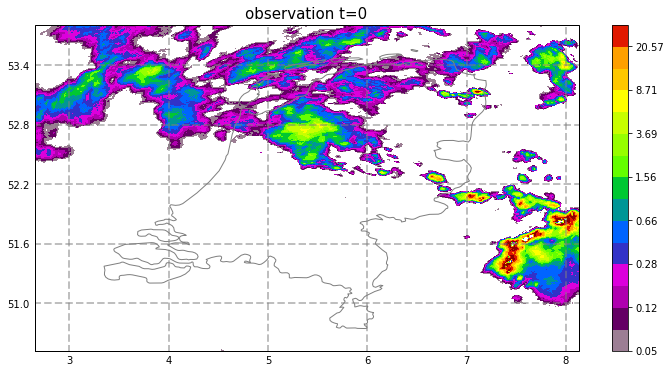

In [153]:
from cartopy.io import shapereader
import numpy as np
import geopandas
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

# get natural earth data (http://www.naturalearthdata.com/)
# this is in coordinate system WGS84 datum
# this information can be found on: https://www.naturalearthdata.com/features/

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# read the german borders
poly = df.loc[df['ADMIN'] == ('Netherlands' or 'Belgium' or 'Germany')]['geometry'].values[0]

def simple_precip_plot(frame, title, norm= new_norm_30, cmap=cmap_pysteps[0]): 
    """
    This function plots the observation or prediction on top of a map of the netherlands, 
    with gridlines indicating the coordinates
    
    frame     = a frame from the forecast or the input data
    title     = the title for the frame you plot, for example: observation t=0, or forecast t=+5 min
    norm norm = type of norm you chose. Can be cmap_pysteps[1] (this is what Eva van der Kooij had used in her thesis,
    I now often use or new_norm_30 to scale to analyse some differences. I do not know yet what I will use in the 
    final maps. Maybe discuss this with Marc?
    cmap      = the colormap: cmap_pysteps[0]
    """
    projection = ccrs.PlateCarree() #ccrs.Stereographic()
    
    plt.figure(figsize=(15,6))
    # Plot the map of the netherlands
    ax = plt.axes(projection=projection) 
    ax.add_geometries(poly, crs=projection, facecolor='none', 
                      edgecolor='0.5')
    ax.set_extent([corr_LAT[0],corr_LAT[-1], corr_LON[-1],corr_LON[0]], crs=projection) 
    
    # Get gridlines and coordinates
    gl = ax.gridlines(crs=projection, draw_labels=True, 
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    # plot the forecast with colorbar
    fig = plt.imshow(frame[60:420, 60:420], cmap=cmap, norm=norm, extent=[corr_LAT[0],corr_LAT[-1], corr_LON[-1],corr_LON[0]])
    plt.colorbar(fig, fraction=0.0476, pad=0.04, orientation='vertical')
    
    plt.title(f'{title}', fontsize=15)
    plt.tight_layout()
    plt.show()
    return fig

simple_precip_plot(input_data[4,0,0,:,:], 'observation t=0')

# Code website: https://www.irenegarciamarti.com/post/extract-rainfall-data-from-radar-files-in-stereo-given-lat-lon-coordinates/

In [109]:
import h5py
import pyproj
import numpy as np
import numpy.ma as ma
from pyproj import Transformer

def pixel_number(lonlist, latlist):

    # A (big) bounding box centered in the NL
    llcrnrlon = 0
    llcrnrlat = 49.36206
    urcrnrlon = 10.856429
    urcrnrlat = 55.388973

    # We specify the width and length of the target raster,
    # in this case rainfall radar files from KNMI
    width = 700
    height = 765

    # We define the two projections used here from a proj4 string. Note that
    # in the original definition of the stereo string in KNMI's documentation the
    # semi-minor/major axes come in km, but it seems pyproj expects meters.
    proj_wgs84 = pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs")
    proj_stereo_rad_nl = pyproj.Proj("+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378140 +b=6356750 +x_0=0 y_0=0")

    # --------------------------------------------------------------------- #
    # Part 1: Reprojections between different systems with pyproj
    # --------------------------------------------------------------------- #

    original_points = list(zip(lonlist, latlist))

    # We transform points from WGS84 to stereo
    i = 1
    transproj_eq = Transformer.from_proj(proj_wgs84, proj_stereo_rad_nl, always_xy=True, skip_equivalent=True)
    llonsstereo, llatsstereo = [[] for i in range(2)]
    print("\nReprojecting #1: WGS84 locations to stereographic")
    for pt in transproj_eq.itransform(original_points):
        lon_stereo = pt[0]
        lat_stereo = pt[1]
        llonsstereo.append(lon_stereo)
        llatsstereo.append(lat_stereo)
        print("\t {0}): {1}, {2} ".format(i, lon_stereo, lat_stereo))
        i += 1

    # ---------------------------------------------------------------------- #
    # Part 2: Getting positions in a stereo raster file with cartopy
    # ---------------------------------------------------------------------- #

    # Small arrays packing together the lat/lons of the NL bbox
    lons_bbox = np.array([llcrnrlon, urcrnrlon])
    lats_bbox = np.array([llcrnrlat, urcrnrlat])
    corners_bbox = list(zip(lons_bbox, lats_bbox))

    i = 0
    print("\nReprojecting #2: WGS84 NL BBOX corners to stereographic)")
    lats_bbox_stereo, lons_bbox_stereo = [[] for i in range(2)]
    for pt in transproj_eq.itransform(corners_bbox):
        lon_stereo = pt[0]
        lat_stereo = pt[1]
        lons_bbox_stereo.append(lon_stereo)
        lats_bbox_stereo.append(lat_stereo)
        print("\t {0}): {1}, {2} ".format(i, lon_stereo, lat_stereo))
        i += 1

    # Define a grid matching exactly the projected stereo corners. Then fill
    # the grid with the actual thresholds of the chunks along both axes
    xs = np.linspace(lons_bbox_stereo[0], lons_bbox_stereo[1], width)
    ys = np.linspace(lats_bbox_stereo[0], lats_bbox_stereo[1], height)
    x2d, y2d = np.meshgrid(xs, ys)

    i = 1
    lpos_xy = []
    transformed_points = list(zip(llonsstereo, llatsstereo))
    print("\nFinding position of stereo point in the radar grid")
    for pt in transformed_points:
        pos = np.where((x2d > pt[0]) & (y2d > pt[1]))
        pos_x = np.amin(pos[0])
        pos_y = np.amin(pos[1])
        lpos_xy.append([pos_x, pos_y])
        print("\t {0}): {1}, {2} ".format(i, pos_x, pos_y))
        i+= 1

    return np.array(lpos_xy)

################
# Main program #
################

path_to_your_radar_file = r"C:\Users\Diewertje\Documents\Master_GRS\New_Thesis\code_for_group\data_event_2018\2018\2018-06-01"
file_name = r"RAD_NL25_PCP_NA_201806011335.h5"

lons = [4.6831494430000005, 4.698676497, 4.867517469, 4.948734154, 4.704202767]
lats = [52.68043576, 52.83607439, 52.75172524, 52.62504707, 52.71969762]

pixel_num = pixel_number(lons, lats)
print(pixel_num)

f = h5py.File(path_to_your_radar_file + file_name)
print(f)
a = f['image1'+'/image_data']
arr_float = np.array(a).astype("float")
arr_masked = ma.masked_equal(arr_float, 65535)
arr_flipped = np.flipud(arr_masked)/100
timestamp = file_name[-15:-3]

# Toggle this to see a 5-min radar image
# plt.imshow(arr_flipped, interpolation="None")
# plt.show()

print("Getting rainfall data from radar file at X/Y positions:")
for i in range(len(lons)):
    xpix = int(pixel_num[i, 0])
    ypix = int(pixel_num[i, 1])
    value = np.round(np.mean(arr_flipped[xpix-1:xpix+2, ypix-1:ypix+2]), decimals=4)
    print("\t X: {0}, Y:{1}, value:{2}".format(xpix, ypix, value ))



Reprojecting #1: WGS84 locations to stereographic
	 1): 328821.2062353422, -4013985.2605606145 
	 2): 328435.09537221567, -3995963.7614448178 
	 3): 341036.326499126, -4004692.6709318305 
	 4): 347976.4484452829, -4018801.16761888 
	 5): 329923.7566923048, -4009339.05980176 

Reprojecting #2: WGS84 NL BBOX corners to stereographic)
	 0): 0.0, -4415003.312762093 
	 1): 700000.9081481533, -3649999.3449603026 

Finding position of stereo point in the radar grid
	 1): 401, 329 
	 2): 419, 328 
	 3): 410, 341 
	 4): 396, 348 
	 5): 406, 330 
[[401 329]
 [419 328]
 [410 341]
 [396 348]
 [406 330]]
<HDF5 file "2018-06-01RAD_NL25_PCP_NA_201806011335.h5" (mode r+)>


KeyError: 'Unable to open object (component not found)'

# Code Marc

In [250]:
#### CODE IN R ######
# get.radar.grid <- function(latlon=TRUE){

#     ## Returns the coordinate grid for KNMI radar products (1x1 km Cartesian)
#     ## Grid size is 700 x 765 pixels
#     ## Coordinates can be given in lat/lon or stereographic projection (km)
#     ## corners are (0,49.36206),(0,55.973602),(10.856429,55.388973),(9.00928,48.8953)    

#     nx <- 700
#     ny <- 765
#     dx <- 1
#     dy <- 1
#     x0 <- 0
#     y0 <- -4415.002329
        
#     seqx <- 1:nx - dx/2 + x0
#     seqy <- rev(1:ny - dy/2 + y0)
#     xy <- expand.grid(seqx,seqy)
    
#     if(latlon==TRUE){
#         proj4string <- "+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378.14 +b=6356.75 +x_0=0 y_0=0"    
#         xy <- convert.cartesian.to.latlon(xy,proj4string)
#     }    
#     return(xy)
# }

#### CODE TRANSLATED TO PYTHON ####
import itertools
import pyproj

def expandgrid(*itrs): # https://stackoverflow.com/a/12131385/1100107
    """
    Cartesian product. Reversion is for compatibility with R.
    
    """
    product = list(itertools.product(*reversed(itrs)))
    return np.array([[x[i] for x in product] for i in range(len(itrs))][::-1])

def get_radar_grid():
    ## Returns the coordinate grid for KNMI radar products (1x1 km Cartesian)
    ## Grid size is 700 x 765 pixels
    ## Coordinates can be given in lat/lon or stereographic projection (m)
    ## corners are (0,49.36206),(0,55.973602),(10.856429,55.388973),(9.00928,48.8953) in WGS84

    nx = 700
    ny = 765
    dx = 1
    dy = 1
    x0 = 0
    y0 = -4415002.329 # needs to be in m instead of km for the pyproj, this is the WGS84 coordinate 49.36206
        
    seqx = np.linspace(1,nx,nx)*1000 - dx/2 + x0
    seqy = np.linspace(ny,1, ny)*1000 - dy/2 + y0
    # select the 360x360 pixels we are interested in
    seqx = seqx[(141+60):(141+420)]
    seqy = seqy[(141+60):(141+420)]
    # make a grid out of it
    xy = expandgrid(seqx,seqy)
    
    # transform these stereographic coordinates to WGS84
    stere = pyproj.Proj("+proj=stere +lat_0=90 +lon_0=0 +lat_ts=60 +a=6378140 +b=6356750 +x_0=0 y_0=0")
    WGS84 = pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs")
    xy[0], xy[1] = pyproj.transform(stere, WGS84, xy[0], xy[1])
    
    return(xy)

coords = get_radar_grid()
coords

array([[ 3.00262612,  3.01746324,  3.03229995, ...,  7.56342869,
         7.57680194,  7.59017435],
       [54.16629952, 54.16584171, 54.16538165, ..., 50.79279656,
        50.79167006, 50.79054159]])

The cell above computes the grid on which the measurements should be plotted. 
Then we use plt.scatter to plot the data at this grid. (in the cell below). 
However, I think we should find something better than plt.scatter, so that we do not get these rounds in the predictions.
And I think I turned the image by accident in the plots above. 

If you now compare this plot with the extend indicated in Eva's image, it is more in agreement. 

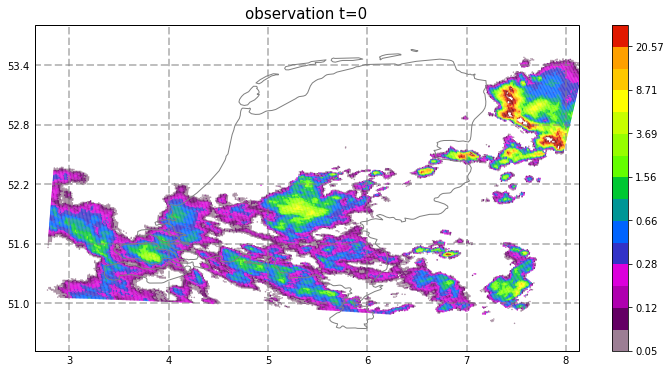

In [249]:
from cartopy.io import shapereader
import numpy as np
import geopandas
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

# get natural earth data (http://www.naturalearthdata.com/)
# this is in coordinate system WGS84 datum
# this information can be found on: https://www.naturalearthdata.com/features/

# get country borders
resolution = '10m'
category = 'cultural'
name = 'admin_0_countries'

shpfilename = shapereader.natural_earth(resolution, category, name)

# read the shapefile using geopandas
df = geopandas.read_file(shpfilename)

# read the german borders
poly = df.loc[df['ADMIN'] == ('Netherlands' or 'Belgium' or 'Germany')]['geometry'].values[0]

def simple_precip_plot(frame, title, norm= new_norm_30, cmap=cmap_pysteps[0]): 
    """
    This function plots the observation or prediction on top of a map of the netherlands, 
    with gridlines indicating the coordinates
    
    frame     = a frame from the forecast or the input data
    title     = the title for the frame you plot, for example: observation t=0, or forecast t=+5 min
    norm norm = type of norm you chose. Can be cmap_pysteps[1] (this is what Eva van der Kooij had used in her thesis,
    I now often use or new_norm_30 to scale to analyse some differences. I do not know yet what I will use in the 
    final maps. Maybe discuss this with Marc?
    cmap      = the colormap: cmap_pysteps[0]
    """
    projection = ccrs.PlateCarree() #ccrs.Stereographic()
    
    plt.figure(figsize=(15,6))
    # Plot the map of the netherlands
    ax = plt.axes(projection=projection) 
    ax.add_geometries(poly, crs=projection, facecolor='none', 
                      edgecolor='0.5')
    ax.set_extent([corr_LAT[0],corr_LAT[-1], corr_LON[-1],corr_LON[0]], crs=projection) 
    
    # Get gridlines and coordinates
    gl = ax.gridlines(crs=projection, draw_labels=True, 
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    # plot the forecast with colorbar
    fig = plt.scatter(coords[0], coords[1], c=frame[60:420,60:420] ,cmap=cmap, norm=norm, s=0.2)
    #plt.imshow(frame[60:420, 60:420], cmap=cmap, norm=norm, extent=[corr_LAT[0],corr_LAT[-1], corr_LON[-1],corr_LON[0]])
    plt.colorbar(fig, fraction=0.0476, pad=0.04, orientation='vertical')
    
    plt.title(f'{title}', fontsize=15)
    plt.tight_layout()
    plt.show()
    return fig

simple_precip_plot(input_data[4,0,0,:,:], 'observation t=0')